In [8]:
def lattice(vertical_vertices, horizontal_vertices, height, width, mesh='auto'):
    'int,int,int-px,int-px,str --> list_coordinates /// mesh can be square which is restricted by the shape while auto will always fit the dimension'
    if mesh == 'auto':
        y_gap = height / (vertical_vertices - 1)
        x_gap = width / (horizontal_vertices - 1)
        vertices = [(i * x_gap, j * y_gap) for j in range(vertical_vertices) for i in range(horizontal_vertices)]
    elif mesh == 'square':
        if vertical_vertices==horizontal_vertices:
            return lattice(vertical_vertices, horizontal_vertices, height, width, 'auto')
        else:
            gap = min(height / (horizontal_vertices - 1), width / (vertical_vertices - 1))
            vertices = [(i * gap, j * gap) for j in range(vertical_vertices) for i in range(horizontal_vertices) if i * gap < width and j * gap < height]
    return vertices

def labels(vertices):
    'list_coordinates --> list_labels /// gives a list of numbers from 0 to len(input)-1'
    return [i for i in range(len(vertices))]

def missing_vertices(vertical_vertices, horizontal_vertices, height, width):
    'int,int,int-px,int-px --> vertex_coordinates'
    gap = min(height / (vertical_vertices - 1), width / (horizontal_vertices - 1))
    actual_horizontal = sum(i * gap < width for i in range(horizontal_vertices))
    actual_vertical = sum(i * gap < height for i in range(vertical_vertices))
    return [vertical_vertices - actual_vertical, horizontal_vertices - actual_horizontal]

def edges(vertical_vertices, horizontal_vertices, labels, mesh='auto'):
    'int, int, list_labels, str --> dict_labels /// gives neighbors of a vertex'
    output = {i: [] for i in labels}
    if mesh == 'auto':
        for i in labels:
            if i >= horizontal_vertices:  # not at the top row
                output[i].append(i - horizontal_vertices)
                if i % horizontal_vertices != 0:  # top-left
                    output[i].append(i - horizontal_vertices - 1)
                if i % horizontal_vertices != horizontal_vertices - 1:  # top-right
                    output[i].append(i - horizontal_vertices + 1)
            if i < horizontal_vertices * (vertical_vertices - 1):  # not at the bottom row
                output[i].append(i + horizontal_vertices)
                if i % horizontal_vertices != 0:  # bottom-left
                    output[i].append(i + horizontal_vertices - 1)
                if i % horizontal_vertices != horizontal_vertices - 1:  # bottom-right
                    output[i].append(i + horizontal_vertices + 1)
            if i % horizontal_vertices != 0:  # not at the left column
                output[i].append(i - 1)
            if i % horizontal_vertices != horizontal_vertices - 1:  # not at the right column
                output[i].append(i + 1)
    elif mesh == 'square':
        for i in labels:
            row = i // horizontal_vertices
            col = i % horizontal_vertices
            if row > 0:  # not at the top row
                output[i].append((row - 1) * horizontal_vertices + col)
                if col > 0:  # top-left
                    output[i].append((row - 1) * horizontal_vertices + col - 1)
                if col < horizontal_vertices - 1:  # top-right
                    output[i].append((row - 1) * horizontal_vertices + col + 1)
            if row < vertical_vertices - 1:  # not at the bottom row
                output[i].append((row + 1) * horizontal_vertices + col)
                if col > 0:  # bottom-left
                    output[i].append((row + 1) * horizontal_vertices + col - 1)
                if col < horizontal_vertices - 1:  # bottom-right
                    output[i].append((row + 1) * horizontal_vertices + col + 1)
            if col > 0:  # not at the left column
                output[i].append(row * horizontal_vertices + col - 1)
            if col < horizontal_vertices - 1:  # not at the right column
                output[i].append(row * horizontal_vertices + col + 1)
    return output

def obstacles(edges, obstacles):
    'dict_labels, list_labels --> dict_labels'
    obstacles_set = set(obstacles)
    # Remove obstacle vertices from the edges dictionary
    for obstacle in obstacles_set:
        if obstacle in edges:
            del edges[obstacle]
    # Remove obstacle vertices from adjacency lists
    for vertex in edges:
        edges[vertex] = [neighbor for neighbor in edges[vertex] if neighbor not in obstacles_set]
    return edges

def vertices_to_path(vertices):
    'list --> list of coordinates'
    return [(vertices[i],vertices[i+1]) for i in range(len(vertices)-1)]

def display_lattice(vertices,special_vertices=[], edges={}, path=[], labels=False):
    'list_coordinates, list_labels, dict_labels, list_coordinates, bool --> None'
    import matplotlib.pyplot as plt
    # Plot vertices
    X = [vertex[0] for vertex in vertices]
    Y = [vertex[1] for vertex in vertices]
    plt.plot(X, Y, 'o', markersize=2, color='blue')
    # Plot edges
    plotted_edges = set()  # To store plotted edges
    for i in edges:
        for neighbor in edges[i]:
            # Plot edge only if not already plotted
            if (i, neighbor) not in plotted_edges and (neighbor, i) not in plotted_edges:
                plt.plot([vertices[i][0], vertices[neighbor][0]], [vertices[i][1], vertices[neighbor][1]], color='grey')
                plotted_edges.add((i, neighbor))  # Add edge to plotted edges
    # Plot path
    for (A, B) in path:
        plt.plot([A[0], B[0]], [A[1], B[1]], color='green', linewidth=2)
    # Special points
    if special_vertices:
        X = [vertices[vertex][0] for vertex in special_vertices]
        Y = [vertices[vertex][1] for vertex in special_vertices]
        plt.plot(X, Y, 'o', markersize=2, color='red')
    # Plot labels if requested
    if labels:
        for i, (x, y) in enumerate(vertices):
            plt.annotate(str(i), (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='red')
    # Plot settings and display
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

def labels_to_coordinates(vertices,edges):
    'list of coordinates,dict of labels --> dict of coordinates'
    return {vertices[i]:[vertices[ii] for ii in edges[i]] for i in edges}

def coordinates_to_labels(ref_vertices,vertices):
    'list of coordinates,list of coordinates --> list of labels'
    return [ref_vertices.index(i) for i in vertices]

def a_star(graph, s0, sf): #graph est une liste d'ajacences en coordoonées #Attention à la taille du graph pour renseigner les points
    'dict_coordinates, coordinates, coordinates --> list_coordinates'
    def weight(s1, s2):
        #return abs(s1[0] - s2[0]) + abs(s1[1] - s2[1]) #distance manhattan
        return ((s1[0] - s2[0])**2+(s1[1] - s2[1])**2)**0.5 #distance carthesian
    open_set = [s0]
    came_from = dict()
    g_score = {vertex: float('inf') for vertex in graph}
    g_score[s0] = 0
    f_score = {vertex: float('inf') for vertex in graph}
    f_score[s0] = weight(s0, sf)
    while open_set: #vide pour une liste, un ensemble ou 0 vaut faux
        s = min(open_set, key=lambda x: f_score[x])
        if s == sf:
            path = []
            while s in came_from:
                path.append(s)
                s = came_from[s]
            path.append(s0)
            return path[::-1]
        open_set.remove(s)
        for neighbor in graph[s]:
            tentative_g_score = g_score[s] + weight(s, neighbor)
            if tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = s
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = g_score[neighbor] + weight(neighbor, sf)
                if neighbor not in open_set:
                    open_set.append(neighbor)
    return None  # If there is no path

#Thm: Tout point d'un plus court chemin fourni un plus court chemin depuis une extrémité.
#Soit O une origine, A une arrivé. En notant les chemins entre parenthèses, on considère alors que (OA) est le chemin le plus court.
#Montrons pour tout M dans (OA) que (OM) fourni un plus court chemin
#Par l'absurde, on suppose que (OM) n'est pas le chemin le plus court alors (OM)+(MA) = (OA) n'est plus le chemin le plus court.
#Donc (OM) est nécessairement le plus court.

def multi_a_star(graph,s0,sf,special_vertices,vertices):
    'dict_coordinates, coordinates, coordinates, list_labels, list_coordinates --> list_coordinates'
    #Define a path order for special_vertices from A*
    #Move to the closest point and star over
    #Then connect to sf
    used=list()
    path=list()
    last_vertex=s0
    while len(used)!=len(special_vertices):
        vertex=min([i for i in special_vertices if i not in used], key=lambda i: len(a_star(graph,s0,vertices[i])))
        path+=a_star(graph,last_vertex,vertices[vertex])[:-1]
        used.append(vertex)
        last_vertex=vertices[vertex]
    path+=a_star(graph,last_vertex,sf)
    return path

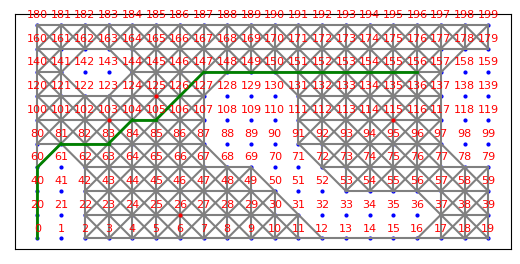

[0, 20, 40, 60, 81, 82, 83, 104, 105, 126, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156]


In [9]:
# Define lattice parameters
vertical_vertices = 10
horizontal_vertices = 20
height = 20
width = 35
mesh = 'square'
# Generate lattice vertices
vertices = lattice(vertical_vertices, horizontal_vertices, height, width, mesh)
special_vertices=[26,115,125,103]
# Define start and finish vertices
s0 = vertices[0]
sf = vertices[156]
# Generate edges and apply obstacles
edge = edges(vertical_vertices, horizontal_vertices, labels(vertices), mesh)
obstacles_list = [1, 21, 41, 61, 88, 89, 90, 108, 109, 110, 128, 129, 130, 98, 99, 118, 119, 138, 139, 158, 159, 142, 143, 35, 36, 33, 34, 70,71,52,51,32]
edge = obstacles(edge, obstacles_list)
# Find solution path
#solution = vertices_to_path(multi_a_star(labels_to_coordinates(vertices, edge), s0, sf, special_vertices,vertices))
solution=vertices_to_path(a_star(labels_to_coordinates(vertices, edge), s0, sf))
# Convert solution to labels
sol_in_labels = coordinates_to_labels(vertices, a_star(labels_to_coordinates(vertices, edge), s0, sf))
# Display lattice with edges and solution
display_lattice(vertices,special_vertices, edge, solution)
print(sol_in_labels)